In [1]:
import os
import time
import math
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (16 , 4) # Set default figure size

print("Tensorflow version", tf.__version__)

G:\Installed\Anaconda\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensorflow version 1.8.0


In [2]:
# Open the file as readonly
h5f = h5py.File('data/SVHN_single_grey.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

# Close this file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (598388, 32, 32, 1) (598388, 10)
Validation set (6000, 32, 32, 1) (6000, 10)
Test set (26032, 32, 32, 1) (26032, 10)


In [3]:
img_size = X_train.shape[1]
num_channels = X_train.shape[-1]
num_classes = y_train.shape[1]
num_channels

1

In [4]:
# Calculate the mean on the training data
train_mean = np.mean(X_train, axis=0)

# Calculate the std on the training data
train_std = np.std(X_train, axis=0)

# Subtract it equally from all splits
X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean)  / train_std
X_val = (train_mean - X_val) / train_std

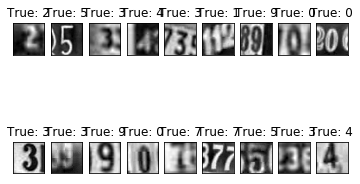

In [5]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Plot nrows * ncols images from images and annotate the images
    """
    # Initialize the subplotgrid
    fig, axes = plt.subplots(nrows, ncols)
    
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        
        # Predictions are not passed
        if cls_pred is None:
            title = "True: {0}".format(np.argmax(cls_true[i]))
        
        # When predictions are passed, display labels + predictions
        else:
            title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), cls_pred[i])  
            
        # Display the image
        ax.imshow(images[i,:,:,0], cmap='binary')
        
        # Annotate the image
        ax.set_title(title)
        
        # Do not overlay a grid
        ax.set_xticks([])
        ax.set_yticks([])
        
        
# Plot 2 rows with 9 images each from the training set
plot_images(X_train, 2, 9, y_train);

In [6]:
def conv_weight_variable(layer_name, shape):
    """ Retrieve an existing variable with the given layer name 
    """
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())

def fc_weight_variable(layer_name, shape):
    """ Retrieve an existing variable with the given layer name
    """
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    """ Creates a new bias variable
    """
    return tf.Variable(tf.constant(0.0, shape=shape))

In [7]:
def conv_layer(input,               # The previous layer
                layer_name,         # Layer name
                num_input_channels, # Num. channels in prev. layer
                filter_size,        # Width and height of each filter
                num_filters,        # Number of filters
                pooling=True):      # Use 2x2 max-pooling

    # Shape of the filter-weights for the convolution
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new filters with the given shape
    weights = conv_weight_variable(layer_name, shape=shape)
    
    # Create new biases, one for each filter
    biases = bias_variable(shape=[num_filters])

    # Create the TensorFlow operation for convolution
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME') # with zero padding

    # Add the biases to the results of the convolution
    layer += biases
    
    # Rectified Linear Unit (RELU)
    layer = tf.nn.relu(layer)

    # Down-sample the image resolution?
    if pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Return the resulting layer and the filter-weights
    return layer, weights

In [8]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The number of features is: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, num_features])

    # Return the flattened layer and the number of features.
    return layer_flat, num_features

In [9]:
def fc_layer(input,        # The previous layer
             layer_name,   # The layer name
             num_inputs,   # Num. inputs from prev. layer
             num_outputs,  # Num. outputs
             relu=True):   # Use RELU?

    # Create new weights and biases.
    weights = fc_weight_variable(layer_name, shape=[num_inputs, num_outputs])
    biases = bias_variable(shape=[num_outputs])

    # Calculate the layer activation
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if relu:
        layer = tf.nn.relu(layer)

    return layer

In [10]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 32         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 64         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 256            # Number of neurons in fully-connected layer.

In [11]:
x = tf.placeholder(tf.float32, shape=(None, img_size, img_size, num_channels), name='x')

y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

y_true_cls = tf.argmax(y_true, axis=1)

keep_prob = tf.placeholder(tf.float32, name = 'keep_prob_node')

In [12]:
#the achitecture is INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL] -> DROPOUT -> [FC -> RELU] -> FC
conv_1, w_c1 = conv_layer(input=x,
                          layer_name="conv_1",
                          num_input_channels=num_channels,
                          filter_size=filter_size1,
                          num_filters=num_filters1, pooling=True)

conv_1

<tf.Tensor 'MaxPool:0' shape=(?, 16, 16, 32) dtype=float32>

In [13]:
conv_2, w_c2 = conv_layer(input=conv_1,
                          layer_name="conv_2",
                          num_input_channels=num_filters1,
                          filter_size=filter_size2,
                          num_filters=num_filters2,
                          pooling=True)

# Apply dropout after the pooling operation
dropout = tf.nn.dropout(conv_2, keep_prob)

dropout

<tf.Tensor 'dropout/mul:0' shape=(?, 8, 8, 64) dtype=float32>

In [14]:
layer_flat, num_features = flatten_layer(dropout)

layer_flat

<tf.Tensor 'Reshape:0' shape=(?, 4096) dtype=float32>

In [15]:
fc_1 = fc_layer(input=layer_flat,
                layer_name="fc_1",
                num_inputs=num_features,
                num_outputs=fc_size,
                relu=True)

fc_1

<tf.Tensor 'Relu_2:0' shape=(?, 256) dtype=float32>

In [16]:
fc_2 = fc_layer(input=fc_1,
                layer_name="fc_2",
                num_inputs=fc_size,
                num_outputs=num_classes,
                relu=False)

fc_2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

In [17]:
y_pred = tf.nn.softmax(fc_2, name = 'out')

# The class-number is the index of the largest element.
y_pred_cls = tf.argmax(y_pred, axis=1)

In [18]:
# Calcualte the cross-entropy# Calcua 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc_2, labels=y_true)

# Take the average of the cross-entropy for all the image classifications.
cost = tf.reduce_mean(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [19]:
# Global step is required to compute the decayed learning rate# Global 
global_step = tf.Variable(0)

# Apply exponential decay to the learning rate
learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.96, staircase=True)

# Construct a new Adam optimizer
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(cost, global_step=global_step)

In [20]:
# Predicted class equals the true class of each image?
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

# Cast predictions to float and calculate the mean
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [21]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config = config)
session.run(tf.global_variables_initializer())

In [22]:
saver = tf.train.Saver()

save_dir = 'checkpoints/'

# Create directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save_path = os.path.join(save_dir, 'svhn_single_greyscale')

In [23]:
#run this to increment training on existing model
saver.restore(sess=session, save_path=save_path)

INFO:tensorflow:Restoring parameters from checkpoints/svhn_single_greyscale


In [24]:
# Number of training samples in each iteration 
batch_size = 64

# Keep probability in dropout layer
dropout = 0.5
y_test.shape

(26032, 10)

In [25]:
total_iterations = 0
def optimize(num_iterations, display_step):
    
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()
    tf.train.write_graph(session.graph_def, 'out',
            'svhn_single_greyscale' + '.pbtxt', True)

    
    for step in range(num_iterations):

        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :, :, :]
        batch_labels = y_train[offset:(offset + batch_size), :]        
        
        feed_dict_train = {x: batch_data, y_true: batch_labels, keep_prob: dropout}

        # Run the optimizer using this batch of training data.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every display_step
        if step % display_step == 0:
            
            # Calculate the accuracy on the training-set.
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)
            print("Minibatch accuracy at step %d: %.4f" % (step, batch_acc))
            
            # Calculate the accuracy on the validation-set
            validation_acc = session.run(accuracy, {x: X_val, y_true: y_val, keep_prob: 1.0})
            print("Validation accuracy: %.4f" % validation_acc)

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Difference between start and end-times.
    time_diff = time.time() - start_time
    
    # Calculate the accuracy on the test-set    
    print(X_test.shape)    
    print(y_test.shape)
    test_accuracy = session.run(accuracy, {x: X_test, y_true: y_test, keep_prob: 1.0})
    
    print("Test accuracy: %.4f" % test_accuracy)
    print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))

In [26]:
X_test = X_test[:15000]
y_test = y_test[:15000]
print(X_test.shape)    
print(y_test.shape)
optimize(num_iterations=5000, display_step=500)

(15000, 32, 32, 1)
(15000, 10)
Minibatch accuracy at step 0: 0.9531
Validation accuracy: 0.9430
Minibatch accuracy at step 500: 0.9531
Validation accuracy: 0.9442
Minibatch accuracy at step 1000: 0.9688
Validation accuracy: 0.9438
Minibatch accuracy at step 1500: 1.0000
Validation accuracy: 0.9455
Minibatch accuracy at step 2000: 0.9688
Validation accuracy: 0.9437
Minibatch accuracy at step 2500: 1.0000
Validation accuracy: 0.9437
Minibatch accuracy at step 3000: 1.0000
Validation accuracy: 0.9437
Minibatch accuracy at step 3500: 0.9844
Validation accuracy: 0.9392
Minibatch accuracy at step 4000: 0.9844
Validation accuracy: 0.9422
Minibatch accuracy at step 4500: 1.0000
Validation accuracy: 0.9432
(15000, 32, 32, 1)
(15000, 10)
Test accuracy: 0.9615
Time usage: 0:00:22


In [27]:
#run this to train the model fully, time taken will depend on your CPU/GPU(preferred)

#optimize(num_iterations=50000, display_step=1000)

In [28]:
saver.save(sess=session, save_path=save_path)
save_path2 = os.path.join('out/', 'svhn_single_greyscale.chkp')
saver.save(sess=session, save_path=save_path2)

'out/svhn_single_greyscale.chkp'

In [29]:
#export the model to a pb file

MODEL_NAME = 'svhn_single_greyscale'
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib
def export_model(input_node_names, output_node_name):
    freeze_graph.freeze_graph('out/' + MODEL_NAME + '.pbtxt', None, False,
        'out/' + MODEL_NAME + '.chkp', output_node_name, "save/restore_all",
        "save/Const:0", 'out/frozen_' + MODEL_NAME + '.pb', True, "")

    input_graph_def = tf.GraphDef()
    with tf.gfile.Open('out/frozen_' + MODEL_NAME + '.pb', "rb") as f:
        input_graph_def.ParseFromString(f.read())

    output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_names, [output_node_name],
            tf.float32.as_datatype_enum)

    with tf.gfile.FastGFile('out/opt_' + MODEL_NAME + '.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())

    print("graph saved!")

In [30]:
export_model(['x','keep_prob_node'], 'out')

INFO:tensorflow:Restoring parameters from out/svhn_single_greyscale.chkp
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.
graph saved!
